In [1]:
from os import listdir
import pandas as pd
import numpy as np

import torch
from torch.utils.data import DataLoader

import Sources.Utils as UtilsTool
import Sources.Attacks as AttacksTool
import Sources.Data as DataTool
from Sources.Models import RNNModel, GRUModel, LSTMModel

In [2]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

device = 'cuda'
DisplayGraph = 1
TrainMode = 1
OptimizeParameters = 1

DatasetPath = 'DatasetRUL/'
ModelPath = 'Models/'
NormalOutputPath = 'ResultsRUL/Normal/'
AdversarialOutputPath = 'ResultsRUL/Adversarial/'
OptimalParametersPath = 'ResultsRUL/OptimalParameters/'
FiguresPath = 'ResultsRUL/Figures/'

window = 80

In [3]:
listdir(DatasetPath)

df_train = pd.read_csv(DatasetPath + 'train_FD001.txt', header = None, sep = ' ')
df_test = pd.read_csv(DatasetPath + 'test_FD001.txt', header = None, sep = ' ')
rul_test = pd.read_csv(DatasetPath + 'RUL_FD001.txt', header = None)

In [4]:
df_train, df_test, rul_test = DataTool.SetDatasets(df_train, df_test, rul_test)

In [5]:
minmax_dict = DataTool.GetMinMaxDictionnary(df_train)
Ndf_train  = DataTool.NormalizeDataset(df_train, minmax_dict)    
Ndf_test  = DataTool.NormalizeDataset(df_test, minmax_dict)   

In [6]:
n_features = len([c for c in Ndf_train.columns if 's' in c])

In [7]:
np.random.seed(5)
torch.manual_seed(5)

units = np.arange(1,101)
train_units = list(np.random.choice(units, 80, replace = False))
val_units = list(set(units) - set(train_units))

train_data = Ndf_train[Ndf_train['unit'].isin(train_units)].copy()
val_data = Ndf_train[Ndf_train['unit'].isin(val_units)].copy()

train_indices = list(train_data[(train_data['rul'] >= (window - 1)) & (train_data['time'] > 10)].index)
val_indices = list(val_data[(val_data['rul'] >= (window - 1)) & (val_data['time'] > 10)].index)

train = DataTool.data(train_indices, Ndf_train, window)
val = DataTool.data(val_indices, Ndf_train, window)

trainloader = DataLoader(train, batch_size = 64, shuffle = True)
valloader = DataLoader(val, batch_size = len(val_indices), shuffle = True)


UnitBySize = Ndf_test.groupby('unit')['time'].max().tolist()
Units = []
for i in range(len(UnitBySize)):
    if UnitBySize[i] > window:
        Units.append(i+1)

testdataset = DataTool.test(Ndf_test, window)
testloader = DataLoader(testdataset, batch_size = 100)


In [8]:
if TrainMode == 1:
    epochs = 30
    learning_rate= 0.001
    
    MyRNNModel = RNNModel(n_features, 12).to(device)
    UtilsTool.InitModel(MyRNNModel, device)
    UtilsTool.TrainModel(MyRNNModel, trainloader, valloader, epochs, learning_rate, device)        
    torch.save(MyRNNModel, ModelPath + 'MyRNNmodel.pth')

    MyGRUModel = GRUModel(n_features, 12).to(device)
    UtilsTool.InitModel(MyGRUModel, device)
    UtilsTool.TrainModel(MyGRUModel, trainloader, valloader, epochs, learning_rate, device)        
    torch.save(MyGRUModel, ModelPath + 'MyGRUmodel.pth')

    MyLSTMModel = LSTMModel(n_features, 12).to(device)
    UtilsTool.InitModel(MyLSTMModel, device)
    UtilsTool.TrainModel(MyLSTMModel, trainloader, valloader, epochs, learning_rate, device)     
    torch.save(MyLSTMModel, ModelPath + 'MyLSTMmodel.pth')
else:
    MyRNNModel = torch.load(ModelPath + 'MyRNNmodel.pth')
    MyGRUModel = torch.load(ModelPath + 'MyGRUmodel.pth')
    MyLSTMModel = torch.load(ModelPath + 'MyLSTMmodel.pth')

In [9]:
MyRNNModel = MyRNNModel.to(device)
MyGRUModel = MyGRUModel.to(device)
MyLSTMModel = MyLSTMModel.to(device)

![](./animation3.gif)

In [10]:
mse, l1, Rrmse, y_pred_rnn, y = UtilsTool.test(MyRNNModel, testloader, device)
print(f'RNN: MSE:{round(mse,2)}, L1:{round(l1,2)}, RMSE:{round(Rrmse,2)}')
mse, l1, Rrmse, y_pred_gru, y = UtilsTool.test(MyGRUModel, testloader, device)
print(f'GRU: MSE:{round(mse,2)}, L1:{round(l1,2)}, RMSE:{round(Rrmse,2)}')
mse, l1, Rrmse, y_pred_lstm, y = UtilsTool.test(MyLSTMModel, testloader, device)
print(f'LSTM: MSE:{round(mse,2)}, L1:{round(l1,2)}, RMSE:{round(Rrmse,2)}')

RNN: MSE:605.93, L1:17.65, RMSE:24.62
GRU: MSE:2738.27, L1:34.23, RMSE:52.33
LSTM: MSE:874.99, L1:21.32, RMSE:29.58


In [11]:
print(y_pred_rnn.shape)

torch.Size([77])


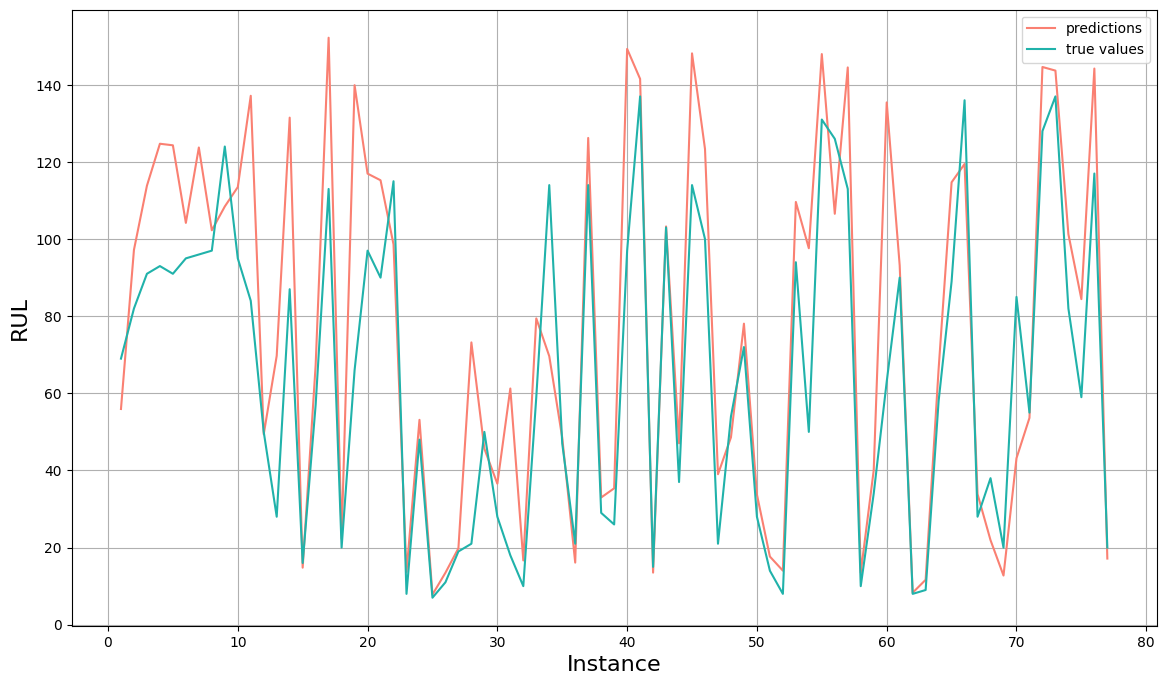

<Figure size 640x480 with 0 Axes>

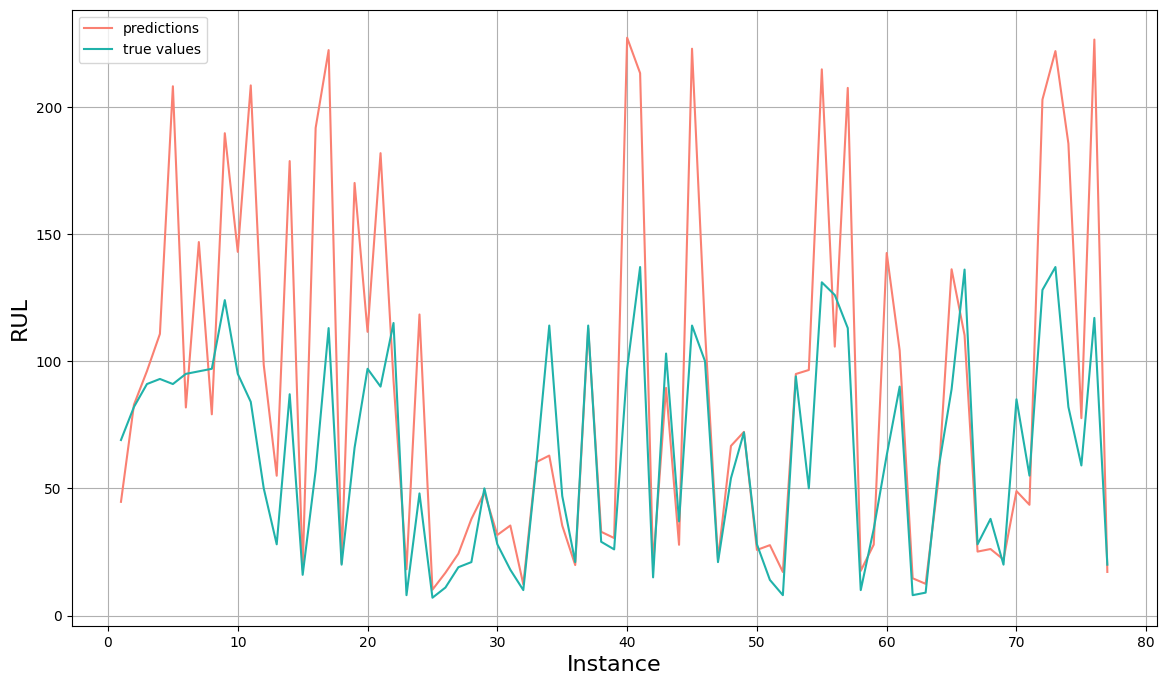

<Figure size 640x480 with 0 Axes>

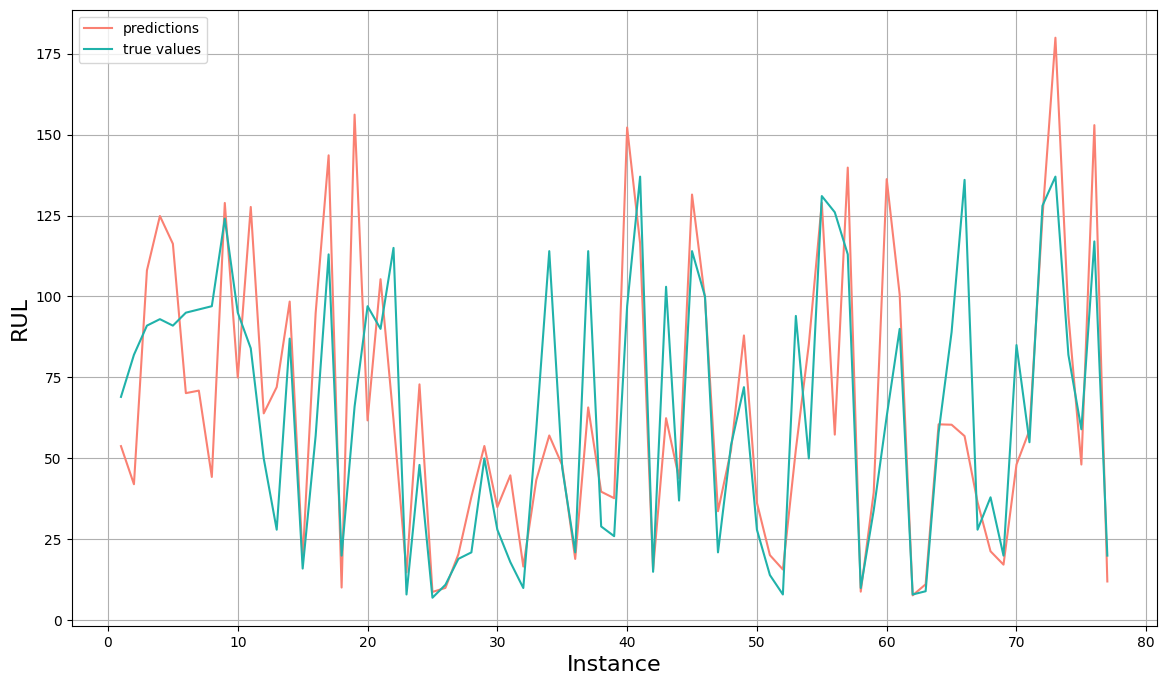

<Figure size 640x480 with 0 Axes>

In [12]:
if DisplayGraph == 1:
    UtilsTool.DisplayGraph(y_pred_rnn, y, FiguresPath, "NormalRNNDetection")
    UtilsTool.DisplayGraph(y_pred_gru, y, FiguresPath, "NormalGRUDetection")
    UtilsTool.DisplayGraph(y_pred_lstm, y, FiguresPath, "NormalLSTMDetection")

In [13]:
testloaderAttack = DataLoader(testloader.dataset, batch_size=100, shuffle=False)
X, y = next(iter(testloaderAttack))
X, y = X.to(device), y.to(device)

AttacksParameters = {
    "FGSM": {
        "Objective": 300,
        "Epsilon": 0.06
    },
    "BIM": {
        "Objective": 300,
        "Iterations": 100,
        "Epsilon": 0.0007
    },
    "CW": {
        "Objective": 0,
        "Iterations": 1000,
        "LearningRate": 0.01,
        "c": 0.005,
    }
}

print("RNN")
RNNAdversarialDataFgsm, RNNAdversarialDataBim, RNNAdversarialDataCW = AttacksTool.TestAttacks(MyRNNModel, X, y, AttacksParameters, device)
print()

AttacksParameters = {
    "FGSM": {
        "Objective": 300,
        "Epsilon": 0.06
    },
    "BIM": {
        "Objective": 300,
        "Iterations": 80,
        "Epsilon": 0.001
    },
    "CW": {
        "Objective": 0,
        "Iterations": 1000,
        "LearningRate": 0.01,
        "c": 0.001,
    }
}

print("GRU")
GRUAdversarialDataFgsm, GRUAdversarialDataBim, GRUAdversarialDataCW = AttacksTool.TestAttacks(MyGRUModel, X, y, AttacksParameters, device)
print()

AttacksParameters = {
    "FGSM": {
        "Objective": 300,
        "Epsilon": 0.055
    },
    "BIM": {
        "Objective": 300,
        "Iterations": 85,
        "Epsilon": 0.001
    },
    "CW": {
        "Objective": 0,
        "Iterations": 1000,
        "LearningRate": 0.01,
        "c": 0.0005,
    }
}

print("LSTM")
LSTMAdversarialDataFgsm, LSTMAdversarialDataBim, LSTMAdversarialDataCW = AttacksTool.TestAttacks(MyLSTMModel, X, y, AttacksParameters, device)

RNN
FGSM: {'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 40.99790573120117, 'RMSE_adversarial': 0.05560315400362015, 'RMSE_pred': 32.53020477294922, 'L0': tensor(23.5455)}
BIM: {'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 34.73389434814453, 'RMSE_adversarial': 0.044009849429130554, 'RMSE_pred': 37.63949966430664, 'L0': tensor(23.4675)}
CW: {'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 0.004488286096602678, 'RMSE_adversarial': 0.045556385070085526, 'RMSE_pred': 75.9988784790039, 'L0': tensor(23.9610)}

GRU
FGSM: {'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 35.36627960205078, 'RMSE_adversarial': 0.05464421212673187, 'RMSE_pred': 46.4670295715332, 'L0': tensor(23.9870)}
BIM: {'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 17.079349517822266, 'RMSE_adversarial': 0.05895489826798439, 'RMSE_pred': 57.7233772277832, 'L0': tensor(24.)}
CW: {'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 0.08834388107061386, 'RMSE_adversarial': 0.04

In [14]:
print("RNN")
PRNNAdversarialDataFgsm = UtilsTool.TestProjectionCost(testloaderAttack, X, RNNAdversarialDataFgsm, MyRNNModel, minmax_dict, window, device)
PRNNAdversarialDataBim = UtilsTool.TestProjectionCost(testloaderAttack, X, RNNAdversarialDataBim, MyRNNModel, minmax_dict, window, device)
PRNNAdversarialDataCW = UtilsTool.TestProjectionCost(testloaderAttack, X, RNNAdversarialDataCW, MyRNNModel, minmax_dict, window, device)

print("GRU")
PGRUAdversarialDataFgsm = UtilsTool.TestProjectionCost(testloaderAttack, X, GRUAdversarialDataFgsm, MyGRUModel, minmax_dict, window, device)
PGRUAdversarialDataBim = UtilsTool.TestProjectionCost(testloaderAttack, X, GRUAdversarialDataBim, MyGRUModel, minmax_dict, window, device)
PGRUAdversarialDataCW = UtilsTool.TestProjectionCost(testloaderAttack, X, GRUAdversarialDataCW, MyGRUModel, minmax_dict, window, device)

print("LSTM")
PLSTMAdversarialDataFgsm = UtilsTool.TestProjectionCost(testloaderAttack, X, LSTMAdversarialDataFgsm, MyLSTMModel, minmax_dict, window, device)
PLSTMAdversarialDataBim = UtilsTool.TestProjectionCost(testloaderAttack, X, LSTMAdversarialDataBim, MyLSTMModel, minmax_dict, window, device)
PLSTMAdversarialDataCW = UtilsTool.TestProjectionCost(testloaderAttack, X, LSTMAdversarialDataCW, MyLSTMModel, minmax_dict, window, device)

RNN
Initial: {'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 40.99790573120117, 'RMSE_adversarial': 0.05560315400362015, 'RMSE_pred': 32.53020477294922, 'L0': tensor(23.5455)}
Formated: {'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 42.23681640625, 'RMSE_adversarial': 0.05165424570441246, 'RMSE_pred': 31.597787857055664, 'L0': tensor(16.)}

Initial: {'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 34.73389434814453, 'RMSE_adversarial': 0.044009849429130554, 'RMSE_pred': 37.63949966430664, 'L0': tensor(23.4675)}
Formated: {'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 36.76939010620117, 'RMSE_adversarial': 0.040258266031742096, 'RMSE_pred': 36.065940856933594, 'L0': tensor(15.9610)}

Initial: {'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 0.004488286096602678, 'RMSE_adversarial': 0.045556385070085526, 'RMSE_pred': 75.9988784790039, 'L0': tensor(23.9610)}
Formated: {'RealRUL': 64.4935073852539, 'Objective': 0, 'PredRUL': 3.148256778717041, '

In [15]:
UtilsTool.CreateDFSFiles(testloaderAttack, X, PRNNAdversarialDataFgsm, y, MyRNNModel, minmax_dict, NormalOutputPath + "/RNN", AdversarialOutputPath + "/RNN" + "/FGSM", device)
UtilsTool.CreateDFSFiles(testloaderAttack, X, PRNNAdversarialDataBim, y, MyRNNModel, minmax_dict, NormalOutputPath + "/RNN", AdversarialOutputPath + "/RNN" + "/BIM", device)
UtilsTool.CreateDFSFiles(testloaderAttack, X, PRNNAdversarialDataCW, y, MyRNNModel, minmax_dict, NormalOutputPath + "/RNN", AdversarialOutputPath + "/RNN" + "/CW", device)

UtilsTool.CreateDFSFiles(testloaderAttack, X, PGRUAdversarialDataFgsm, y, MyGRUModel, minmax_dict, NormalOutputPath + "/GRU", AdversarialOutputPath + "/GRU" + "/FGSM", device)
UtilsTool.CreateDFSFiles(testloaderAttack, X, PGRUAdversarialDataBim, y, MyGRUModel, minmax_dict, NormalOutputPath + "/GRU", AdversarialOutputPath + "/GRU" + "/BIM", device)
UtilsTool.CreateDFSFiles(testloaderAttack, X, PGRUAdversarialDataCW, y, MyGRUModel, minmax_dict, NormalOutputPath + "/GRU", AdversarialOutputPath + "/GRU" + "/CW", device)

UtilsTool.CreateDFSFiles(testloaderAttack, X, PLSTMAdversarialDataFgsm, y, MyLSTMModel, minmax_dict, NormalOutputPath + "/LSTM", AdversarialOutputPath + "/LSTM" + "/FGSM", device)
UtilsTool.CreateDFSFiles(testloaderAttack, X, PLSTMAdversarialDataBim, y, MyLSTMModel, minmax_dict, NormalOutputPath + "/LSTM", AdversarialOutputPath + "/LSTM" + "/BIM", device)
UtilsTool.CreateDFSFiles(testloaderAttack, X, PLSTMAdversarialDataCW, y, MyLSTMModel, minmax_dict, NormalOutputPath + "/LSTM", AdversarialOutputPath + "/LSTM" + "/CW", device)

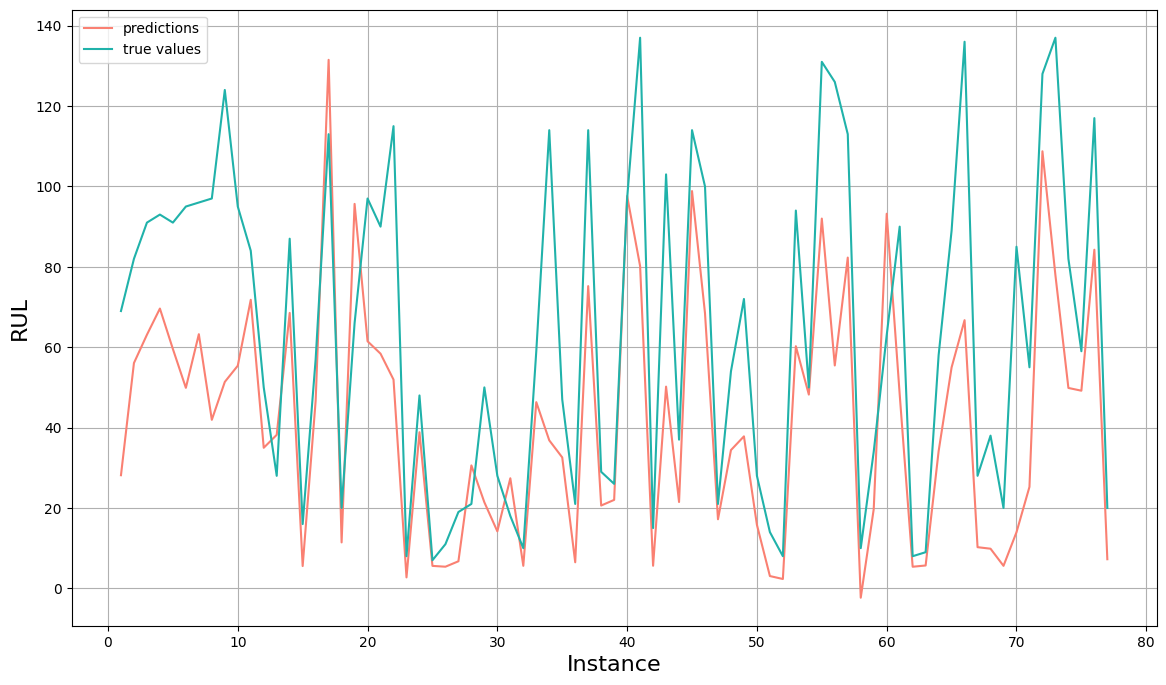

<Figure size 640x480 with 0 Axes>

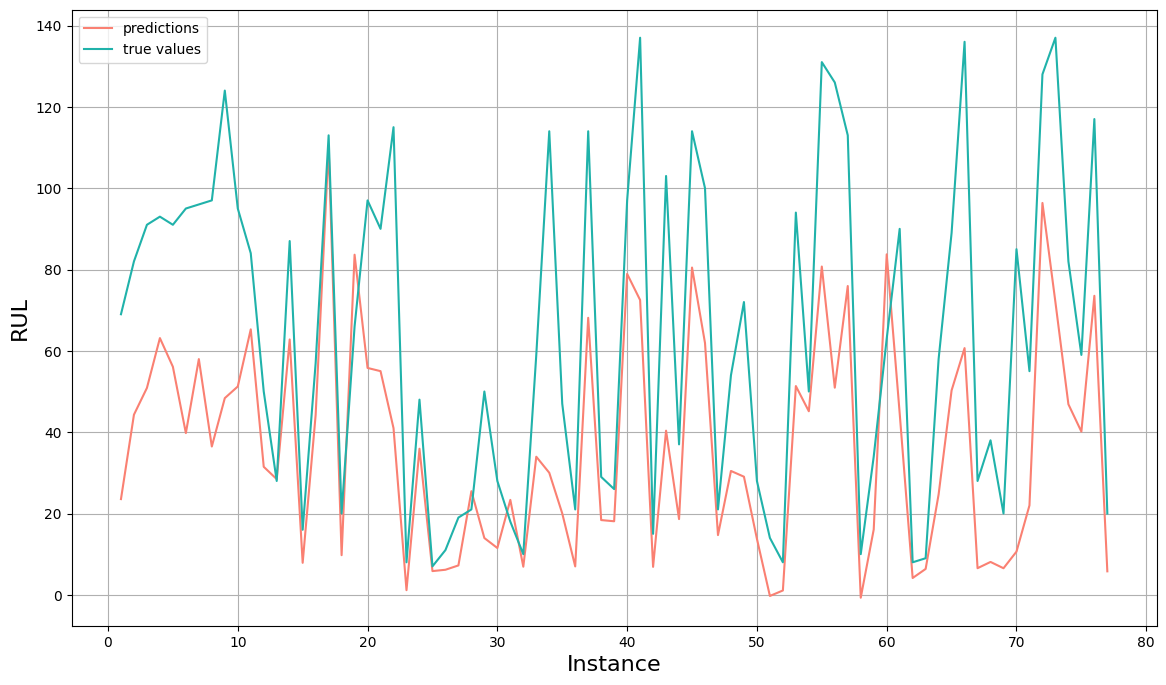

<Figure size 640x480 with 0 Axes>

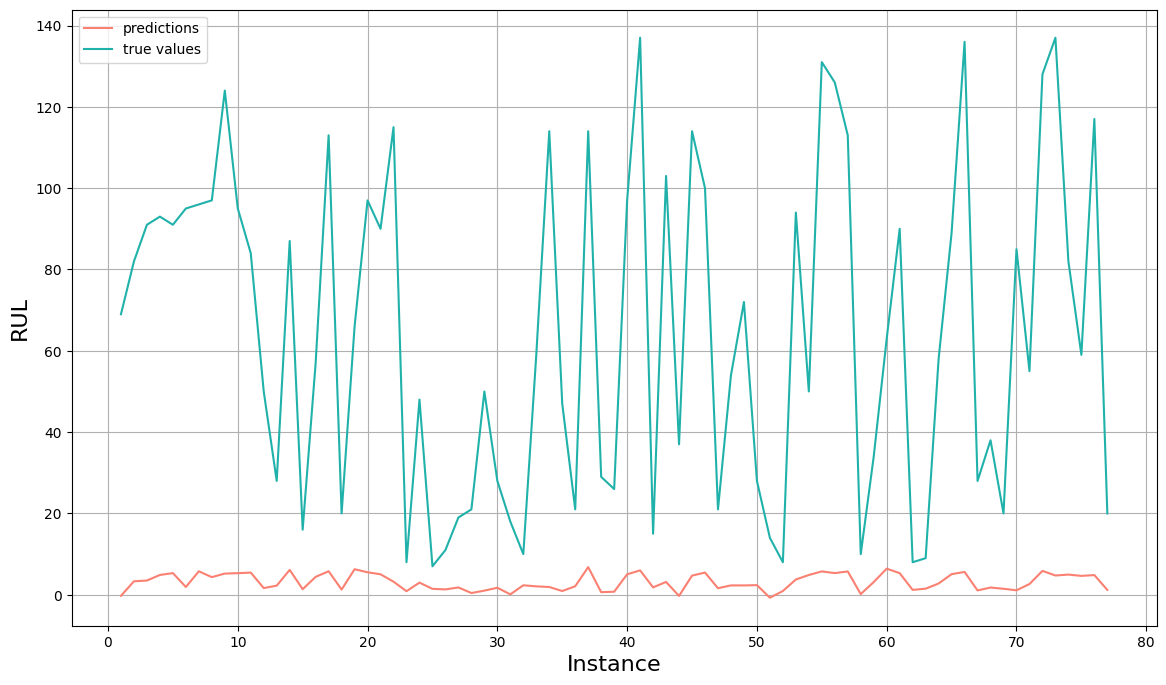

<Figure size 640x480 with 0 Axes>

In [16]:
if DisplayGraph == 1:
    y_pred = MyRNNModel(PRNNAdversarialDataFgsm)
    UtilsTool.DisplayGraph(y_pred, y, FiguresPath, "FGSMRNNDetection")
    y_pred = MyRNNModel(PRNNAdversarialDataBim)
    UtilsTool.DisplayGraph(y_pred, y, FiguresPath, "BIMRNNDetection")
    y_pred = MyRNNModel(PRNNAdversarialDataCW)
    UtilsTool.DisplayGraph(y_pred, y, FiguresPath, "CWRNNDetection")

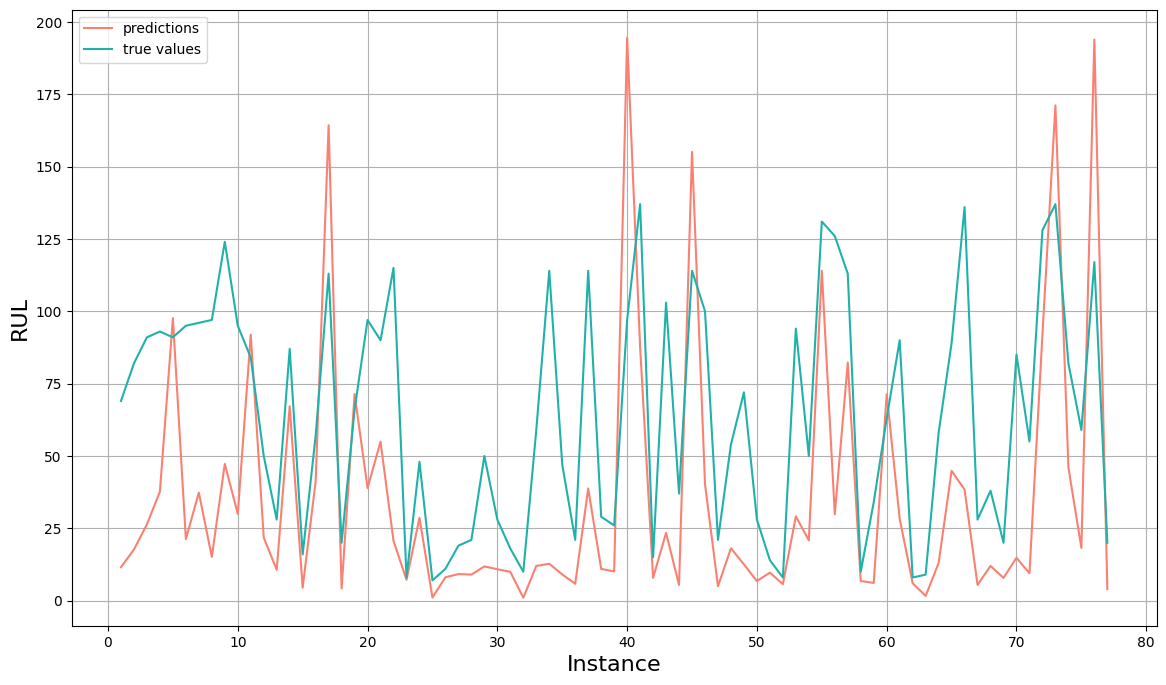

<Figure size 640x480 with 0 Axes>

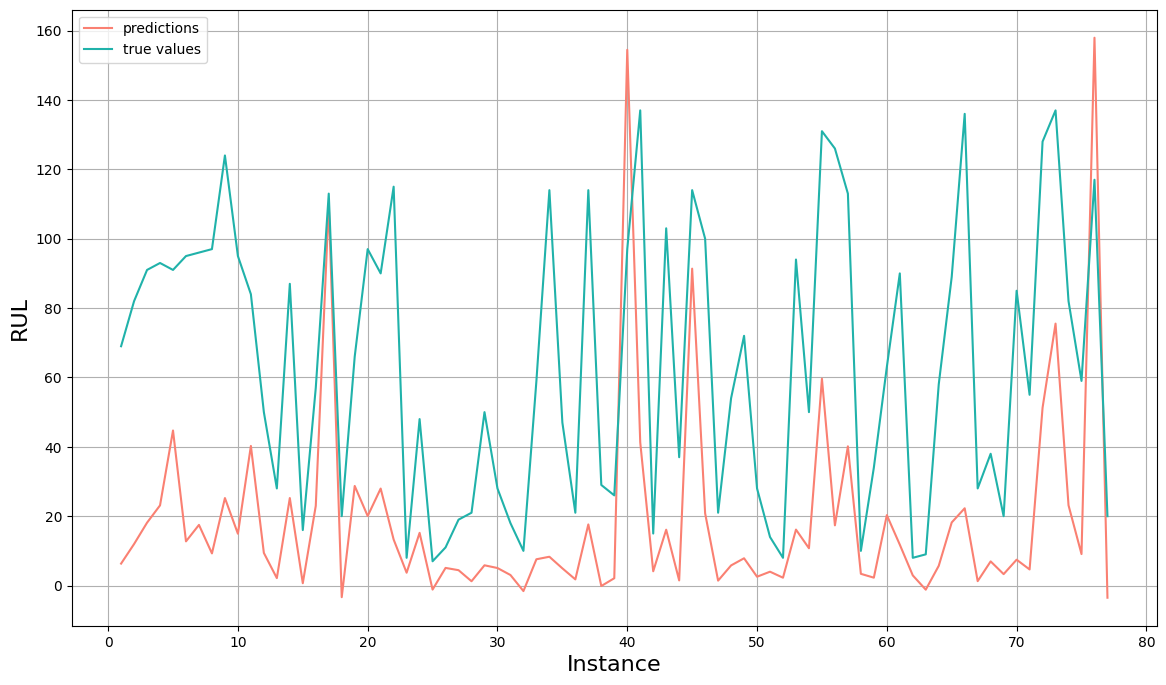

<Figure size 640x480 with 0 Axes>

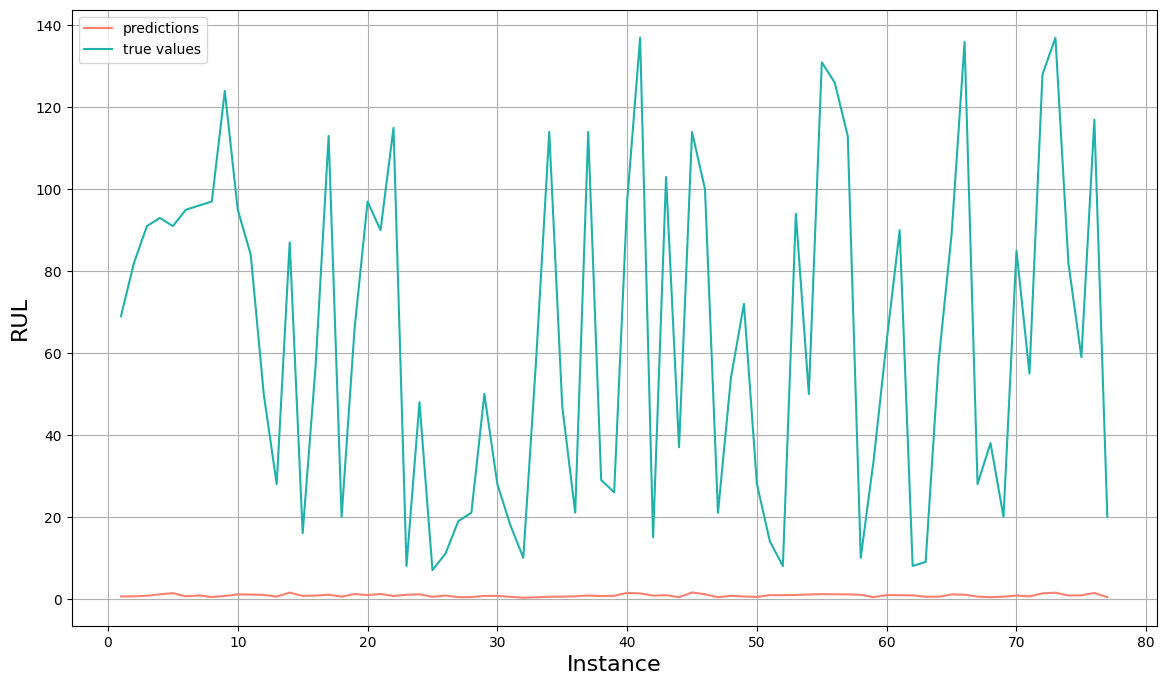

<Figure size 640x480 with 0 Axes>

In [17]:
if DisplayGraph == 1:
    y_pred = MyGRUModel(PGRUAdversarialDataFgsm)
    UtilsTool.DisplayGraph(y_pred, y, FiguresPath, "FGSMGRUDetection")
    y_pred = MyGRUModel(PGRUAdversarialDataBim)
    UtilsTool.DisplayGraph(y_pred, y, FiguresPath, "BIMGRUDetection")
    y_pred = MyGRUModel(PGRUAdversarialDataCW)
    UtilsTool.DisplayGraph(y_pred, y, FiguresPath, "CWGRUDetection")

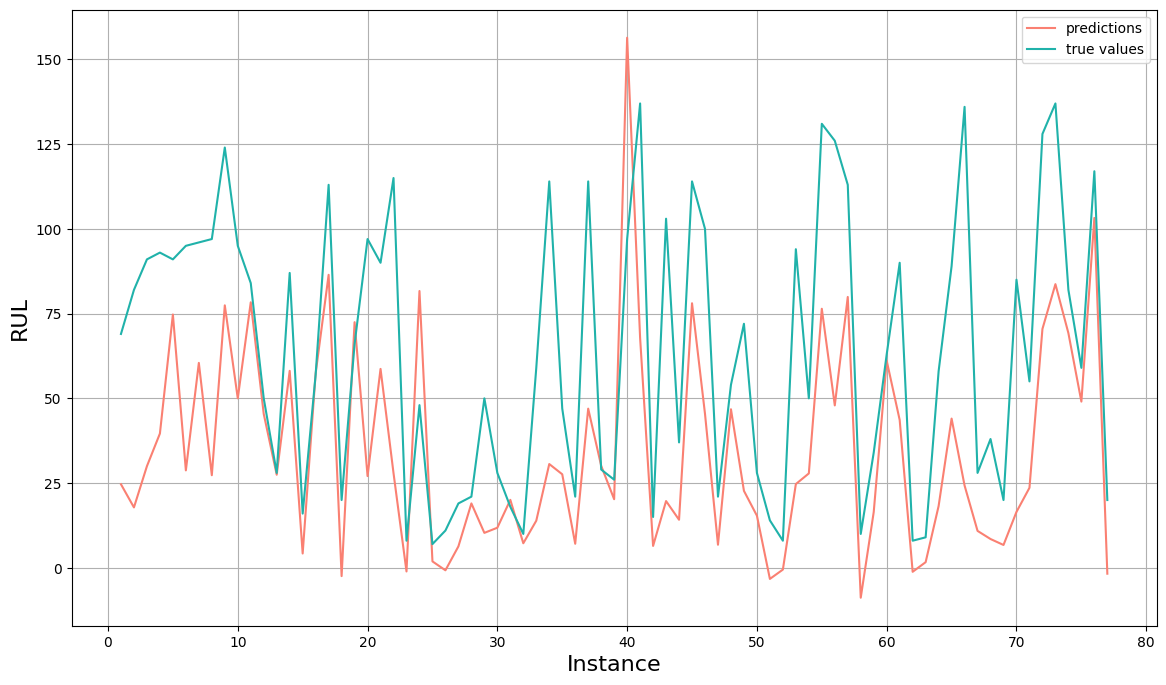

<Figure size 640x480 with 0 Axes>

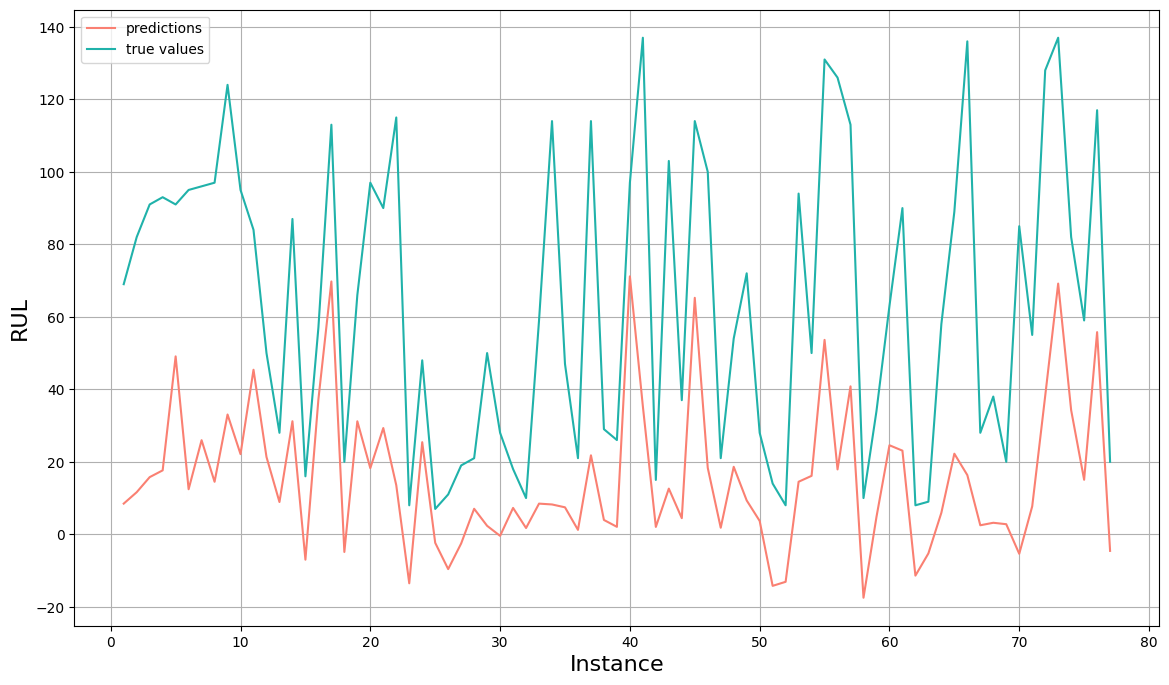

<Figure size 640x480 with 0 Axes>

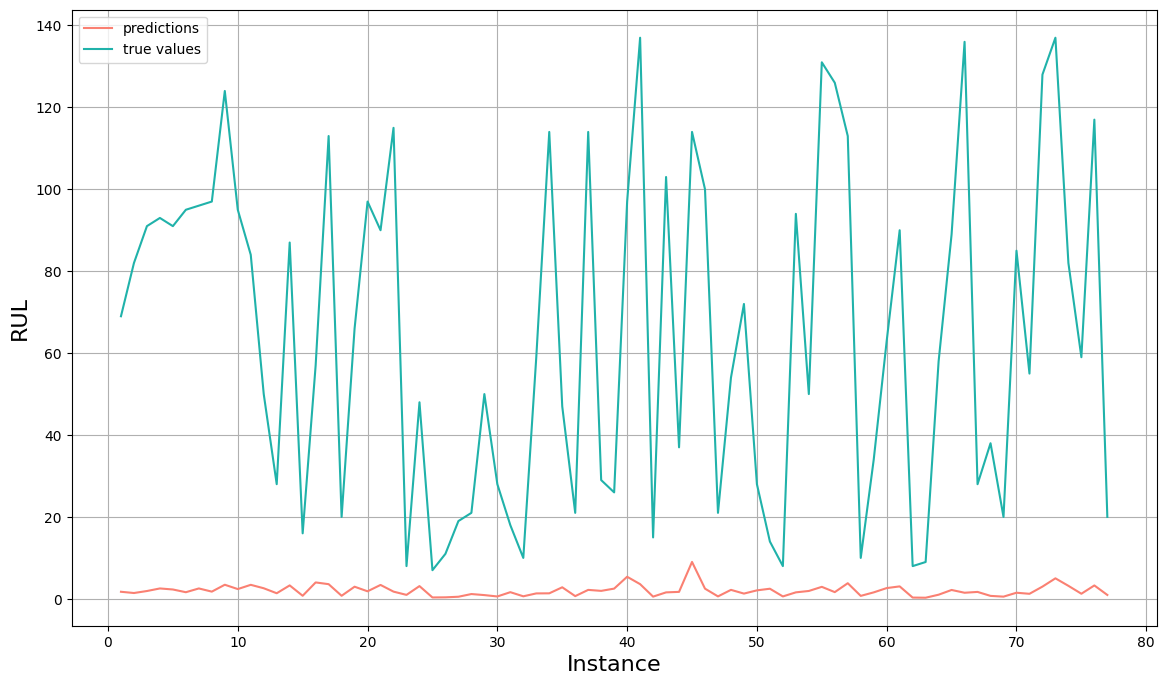

<Figure size 640x480 with 0 Axes>

In [18]:
if DisplayGraph == 1:
    y_pred = MyLSTMModel(PLSTMAdversarialDataFgsm)
    UtilsTool.DisplayGraph(y_pred, y, FiguresPath, "FGSMLSTMDetection")
    y_pred = MyLSTMModel(PLSTMAdversarialDataBim)
    UtilsTool.DisplayGraph(y_pred, y, FiguresPath, "BIMLSTMDetection")
    y_pred = MyLSTMModel(PLSTMAdversarialDataCW)
    UtilsTool.DisplayGraph(y_pred, y, FiguresPath, "CWLSTMDetection")

In [26]:
if OptimizeParameters == 1:
    AttacksTool.OptimizeParameters(X, y, MyGRUModel, OptimalParametersPath, device)

AttributeError: 'dict' object has no attribute 'OptimizeParameters'

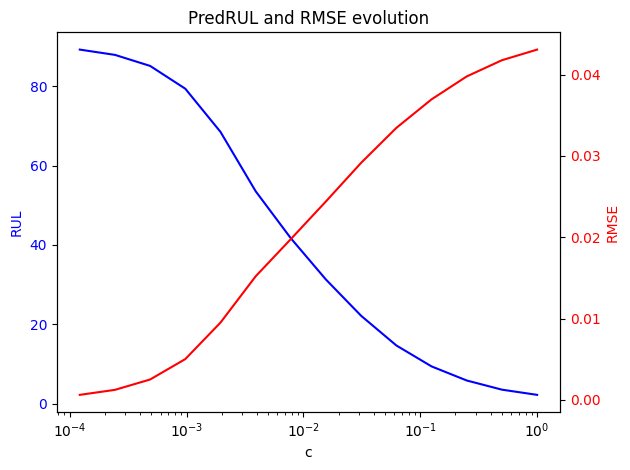

1 {'RealRUL': 75.5199966430664, 'Objective': 0, 'PredRUL': 0.05039050430059433, 'RMSE_adversarial': 0.07817182689905167, 'RMSE_pred': 86.15467071533203, 'L0': tensor(15.7300), 'c': 1}
0.5 {'RealRUL': 75.5199966430664, 'Objective': 0, 'PredRUL': 0.1475161761045456, 'RMSE_adversarial': 0.06939812004566193, 'RMSE_pred': 86.09998321533203, 'L0': tensor(14.1400), 'c': 0.5}
0.25 {'RealRUL': 75.5199966430664, 'Objective': 0, 'PredRUL': 0.501319408416748, 'RMSE_adversarial': 0.061200208961963654, 'RMSE_pred': 85.8917465209961, 'L0': tensor(12.4300), 'c': 0.25}
0.125 {'RealRUL': 75.5199966430664, 'Objective': 0, 'PredRUL': 0.5356002449989319, 'RMSE_adversarial': 0.05631034076213837, 'RMSE_pred': 85.81527709960938, 'L0': tensor(11.2800), 'c': 0.125}
0.0625 {'RealRUL': 75.5199966430664, 'Objective': 0, 'PredRUL': 0.955573558807373, 'RMSE_adversarial': 0.0513770654797554, 'RMSE_pred': 85.54895782470703, 'L0': tensor(9.8900), 'c': 0.0625}
0.03125 {'RealRUL': 75.5199966430664, 'Objective': 0, 'PredR

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [ ]:
if DisplayGraph == 1:
    AttacksParametersMaillard = {
        "Maillard": {
            "Objective": 0,
            "Iterations": 1000,
            "LearningRate": 0.01,
            "Initial_c": 1,
            "Final_c": 0.0001,
            "Steps_c":2,
            "k": 1,
            "P": 5,
            "S": 0.03

        }
    }
    AttacksTool.TestNewAttacks(MyRNNModel, X, y, AttacksParametersMaillard, device, FiguresPath, "NewAttackRNN_C_")
    
    AttacksParametersMaillard = {
        "Maillard": {
            "Objective": 0,
            "Iterations": 1000,
            "LearningRate": 0.01,
            "Initial_c": 1,
            "Final_c": 0.0001,
            "Steps_c":2,
            "k": 1,
            "P": 5,
            "S": 0.03

        }
    }
    AttacksTool.TestNewAttacks(MyGRUModel, X, y, AttacksParametersMaillard, device, FiguresPath, "NewAttackGRU_C_")
    
    AttacksParametersMaillard = {
        "Maillard": {
            "Objective": 0,
            "Iterations": 1000,
            "LearningRate": 0.01,
            "Initial_c": 1,
            "Final_c": 0.0001,
            "Steps_c":2,
            "k": 1,
            "P": 5,
            "S": 0.03

        }
    }
    AttacksTool.TestNewAttacks(MyLSTMModel, X, y, AttacksParametersMaillard, device, FiguresPath, "NewAttackLSTM_C_")

In [ ]:
RNNAdversarialDataMaillardL2 = AttacksTool.MaillardL2(MyRNNModel, 0, X.float(), y.float(), 0.01, 1, 1000, device)
Infos = UtilsTool.GetInfos(X, y, 0, RNNAdversarialDataMaillardL2, MyRNNModel)
print("Maillard-L0:", Infos)

GRUAdversarialDataMaillardL2 = AttacksTool.MaillardL2(MyGRUModel, 0, X.float(), y.float(), 0.01, 1, 1000, device)
Infos = UtilsTool.GetInfos(X, y, 0, GRUAdversarialDataMaillardL2, MyGRUModel)
print("Maillard-L0:", Infos)

LSTMAdversarialDataMaillardL2 = AttacksTool.MaillardL2(MyLSTMModel, 0, X.float(), y.float(), 0.01, 1, 1000, device)
Infos = UtilsTool.GetInfos(X, y, 0, LSTMAdversarialDataMaillardL2, MyLSTMModel)
print("Maillard-L0:", Infos)


Maillard-L0: {'RealRUL': 75.5199966430664, 'Objective': 0, 'PredRUL': 2.270536184310913, 'RMSE_adversarial': 0.04307234659790993, 'RMSE_pred': 84.24278259277344, 'L0': tensor(23.6600)}
Maillard-L0: {'RealRUL': 75.5199966430664, 'Objective': 0, 'PredRUL': 2.5234124660491943, 'RMSE_adversarial': 0.0388496108353138, 'RMSE_pred': 84.29486083984375, 'L0': tensor(23.8000)}
Maillard-L0: {'RealRUL': 75.5199966430664, 'Objective': 0, 'PredRUL': 4.177488327026367, 'RMSE_adversarial': 0.057331427931785583, 'RMSE_pred': 81.98155975341797, 'L0': tensor(22.9500)}


In [ ]:
RNNAdversarialDataMaillardL0 = AttacksTool.MaillardL0(MyRNNModel, 0, X.float(), y.float(), 0.01, 0.01, 1000, 1, 5, 0.03, device)
Infos = UtilsTool.GetInfos(X, y, 0, RNNAdversarialDataMaillardL0, MyRNNModel)
print("Maillard-L0:", Infos)

GRUAdversarialDataMaillardL0 = AttacksTool.MaillardL0(MyGRUModel, 0, X.float(), y.float(), 0.01, 0.01, 1000, 1, 5, 0.03, device)
Infos = UtilsTool.GetInfos(X, y, 0, GRUAdversarialDataMaillardL0, MyGRUModel)
print("Maillard-L0:", Infos)

LSTMAdversarialDataMaillardL0 = AttacksTool.MaillardL0(MyLSTMModel, 0, X.float(), y.float(), 0.01, 0.01, 1000, 1, 5, 0.03, device)
Infos = UtilsTool.GetInfos(X, y, 0, LSTMAdversarialDataMaillardL0, MyLSTMModel)
print("Maillard-L0:", Infos)

Maillard-L0: {'RealRUL': 75.5199966430664, 'Objective': 0, 'PredRUL': 2.829861879348755, 'RMSE_adversarial': 0.04572167992591858, 'RMSE_pred': 83.883544921875, 'L0': tensor(7.0400)}
Maillard-L0: {'RealRUL': 75.5199966430664, 'Objective': 0, 'PredRUL': 2.812343120574951, 'RMSE_adversarial': 0.04026252031326294, 'RMSE_pred': 84.06428527832031, 'L0': tensor(10.3700)}
Maillard-L0: {'RealRUL': 75.5199966430664, 'Objective': 0, 'PredRUL': 3.8692822456359863, 'RMSE_adversarial': 0.08051847666501999, 'RMSE_pred': 82.70358276367188, 'L0': tensor(8.2000)}


In [ ]:
print("RNN")
PRNNAdversarialDataMaillardL2 = UtilsTool.TestProjectionCost(testloaderAttack, X, RNNAdversarialDataMaillardL2, MyRNNModel, minmax_dict, window, device)
PRNNAdversarialDataMaillardL0 = UtilsTool.TestProjectionCost(testloaderAttack, X, RNNAdversarialDataMaillardL0, MyRNNModel, minmax_dict, window, device)
print("GRU")
PGRUAdversarialDataMaillardL2 = UtilsTool.TestProjectionCost(testloaderAttack, X, GRUAdversarialDataMaillardL2, MyRNNModel, minmax_dict, window, device)
PGRUAdversarialDataMaillardL0 = UtilsTool.TestProjectionCost(testloaderAttack, X, GRUAdversarialDataMaillardL0, MyRNNModel, minmax_dict, window, device)
print("LSTM")
PLSTMAdversarialDataMaillardL2 = UtilsTool.TestProjectionCost(testloaderAttack, X, LSTMAdversarialDataMaillardL2, MyRNNModel, minmax_dict, window, device)
PLSTMAdversarialDataMaillardL0 = UtilsTool.TestProjectionCost(testloaderAttack, X, LSTMAdversarialDataMaillardL0, MyRNNModel, minmax_dict, window, device)

RNN
Initial: {'RealRUL': 75.5199966430664, 'Objective': 0, 'PredRUL': 2.270536184310913, 'RMSE_adversarial': 0.04307234659790993, 'RMSE_pred': 84.24278259277344, 'L0': tensor(23.6600)}
Formated: {'RealRUL': 75.5199966430664, 'Objective': 0, 'PredRUL': 3.932441234588623, 'RMSE_adversarial': 0.04242781922221184, 'RMSE_pred': 82.70484924316406, 'L0': tensor(14.4700)}

Initial: {'RealRUL': 75.5199966430664, 'Objective': 0, 'PredRUL': 2.829861879348755, 'RMSE_adversarial': 0.04572167992591858, 'RMSE_pred': 83.883544921875, 'L0': tensor(7.0400)}
Formated: {'RealRUL': 75.5199966430664, 'Objective': 0, 'PredRUL': 3.0444977283477783, 'RMSE_adversarial': 0.045633815228939056, 'RMSE_pred': 83.66011047363281, 'L0': tensor(6.9300)}

GRU
Initial: {'RealRUL': 75.5199966430664, 'Objective': 0, 'PredRUL': 51.431640625, 'RMSE_adversarial': 0.0388496108353138, 'RMSE_pred': 34.59782791137695, 'L0': tensor(23.8000)}
Formated: {'RealRUL': 75.5199966430664, 'Objective': 0, 'PredRUL': 51.59794616699219, 'RMSE

In [ ]:
UtilsTool.CreateDFSFiles(testloaderAttack, X, PRNNAdversarialDataMaillardL2, y, MyRNNModel, minmax_dict, NormalOutputPath + "/RNN", AdversarialOutputPath + "/RNN" + "/L2", device)
UtilsTool.CreateDFSFiles(testloaderAttack, X, PRNNAdversarialDataMaillardL0, y, MyRNNModel, minmax_dict, NormalOutputPath + "/RNN", AdversarialOutputPath + "/RNN" + "/L0", device)

UtilsTool.CreateDFSFiles(testloaderAttack, X, PGRUAdversarialDataMaillardL2, y, MyGRUModel, minmax_dict, NormalOutputPath + "/GRU", AdversarialOutputPath + "/GRU" + "/L2", device)
UtilsTool.CreateDFSFiles(testloaderAttack, X, PGRUAdversarialDataMaillardL0, y, MyGRUModel, minmax_dict, NormalOutputPath + "/GRU", AdversarialOutputPath + "/GRU" + "/L0", device)

UtilsTool.CreateDFSFiles(testloaderAttack, X, PLSTMAdversarialDataMaillardL2, y, MyLSTMModel, minmax_dict, NormalOutputPath + "/LSTM", AdversarialOutputPath + "/LSTM" + "/L2", device)
UtilsTool.CreateDFSFiles(testloaderAttack, X, PLSTMAdversarialDataMaillardL0, y, MyLSTMModel, minmax_dict, NormalOutputPath + "/LSTM", AdversarialOutputPath + "/LSTM" + "/L0", device)

In [ ]:
print("Transferability RNN")
Infos = UtilsTool.GetInfos(X, y, 0, PRNNAdversarialDataFgsm, MyRNNModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PRNNAdversarialDataBim, MyRNNModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PRNNAdversarialDataCW, MyRNNModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PRNNAdversarialDataMaillardL2, MyRNNModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PRNNAdversarialDataMaillardL0, MyRNNModel)
print(Infos)
print()
Infos = UtilsTool.GetInfos(X, y, 0, PGRUAdversarialDataFgsm, MyRNNModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PGRUAdversarialDataBim, MyRNNModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PGRUAdversarialDataCW, MyRNNModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PGRUAdversarialDataMaillardL2, MyRNNModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PGRUAdversarialDataMaillardL0, MyRNNModel)
print(Infos)
print()
Infos = UtilsTool.GetInfos(X, y, 0, PLSTMAdversarialDataFgsm, MyRNNModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PLSTMAdversarialDataBim, MyRNNModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PLSTMAdversarialDataCW, MyRNNModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PLSTMAdversarialDataMaillardL2, MyRNNModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PLSTMAdversarialDataMaillardL0, MyRNNModel)
print(Infos)

Transferability RNN
{'RealRUL': 75.5199966430664, 'Objective': 0, 'PredRUL': 51.960975646972656, 'RMSE_adversarial': 0.051658663898706436, 'RMSE_pred': 32.830265045166016, 'L0': tensor(16.)}
{'RealRUL': 75.5199966430664, 'Objective': 0, 'PredRUL': 45.09031295776367, 'RMSE_adversarial': 0.04939906299114227, 'RMSE_pred': 38.3547248840332, 'L0': tensor(15.9700)}
{'RealRUL': 75.5199966430664, 'Objective': 0, 'PredRUL': 3.653381824493408, 'RMSE_adversarial': 0.0774320736527443, 'RMSE_pred': 82.25989532470703, 'L0': tensor(15.8000)}
{'RealRUL': 75.5199966430664, 'Objective': 0, 'PredRUL': 3.932441234588623, 'RMSE_adversarial': 0.04242781922221184, 'RMSE_pred': 82.70484924316406, 'L0': tensor(14.4700)}
{'RealRUL': 75.5199966430664, 'Objective': 0, 'PredRUL': 3.0444977283477783, 'RMSE_adversarial': 0.045633815228939056, 'RMSE_pred': 83.66011047363281, 'L0': tensor(6.9300)}

{'RealRUL': 75.5199966430664, 'Objective': 0, 'PredRUL': 56.980682373046875, 'RMSE_adversarial': 0.05165906623005867, 'RM

In [ ]:
print("Transferability GRU")
Infos = UtilsTool.GetInfos(X, y, 0, PRNNAdversarialDataFgsm, MyGRUModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PRNNAdversarialDataBim, MyGRUModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PRNNAdversarialDataCW, MyGRUModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PRNNAdversarialDataMaillardL2, MyGRUModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PRNNAdversarialDataMaillardL0, MyGRUModel)
print(Infos)
print()
Infos = UtilsTool.GetInfos(X, y, 0, PGRUAdversarialDataFgsm, MyGRUModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PGRUAdversarialDataBim, MyGRUModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PGRUAdversarialDataCW, MyGRUModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PGRUAdversarialDataMaillardL2, MyGRUModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PGRUAdversarialDataMaillardL0, MyGRUModel)
print(Infos)
print()
Infos = UtilsTool.GetInfos(X, y, 0, PLSTMAdversarialDataFgsm, MyGRUModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PLSTMAdversarialDataBim, MyGRUModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PLSTMAdversarialDataCW, MyGRUModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PLSTMAdversarialDataMaillardL2, MyRNNModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PLSTMAdversarialDataMaillardL0, MyRNNModel)
print(Infos)

Transferability GRU
{'RealRUL': 75.5199966430664, 'Objective': 0, 'PredRUL': 52.07351303100586, 'RMSE_adversarial': 0.051658663898706436, 'RMSE_pred': 33.198768615722656, 'L0': tensor(16.)}
{'RealRUL': 75.5199966430664, 'Objective': 0, 'PredRUL': 46.96047592163086, 'RMSE_adversarial': 0.04939906299114227, 'RMSE_pred': 38.64871597290039, 'L0': tensor(15.9700)}
{'RealRUL': 75.5199966430664, 'Objective': 0, 'PredRUL': 8.10840892791748, 'RMSE_adversarial': 0.0774320736527443, 'RMSE_pred': 81.2879409790039, 'L0': tensor(15.8000)}
{'RealRUL': 75.5199966430664, 'Objective': 0, 'PredRUL': 26.647411346435547, 'RMSE_adversarial': 0.04242781922221184, 'RMSE_pred': 60.302791595458984, 'L0': tensor(14.4700)}
{'RealRUL': 75.5199966430664, 'Objective': 0, 'PredRUL': 28.646278381347656, 'RMSE_adversarial': 0.045633815228939056, 'RMSE_pred': 58.12457275390625, 'L0': tensor(6.9300)}

{'RealRUL': 75.5199966430664, 'Objective': 0, 'PredRUL': 16.617393493652344, 'RMSE_adversarial': 0.05165906623005867, 'RM

In [ ]:
print("Transferability LSTM")

Infos = UtilsTool.GetInfos(X, y, 0, PRNNAdversarialDataFgsm, MyLSTMModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PRNNAdversarialDataBim, MyLSTMModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PRNNAdversarialDataCW, MyLSTMModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PRNNAdversarialDataMaillardL2, MyLSTMModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PRNNAdversarialDataMaillardL0, MyLSTMModel)
print(Infos)
print()
Infos = UtilsTool.GetInfos(X, y, 0, PGRUAdversarialDataFgsm, MyLSTMModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PGRUAdversarialDataBim, MyLSTMModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PGRUAdversarialDataCW, MyLSTMModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PGRUAdversarialDataMaillardL2, MyLSTMModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PGRUAdversarialDataMaillardL0, MyLSTMModel)
print(Infos)
print()
Infos = UtilsTool.GetInfos(X, y, 0, PLSTMAdversarialDataFgsm, MyLSTMModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PLSTMAdversarialDataBim, MyLSTMModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PLSTMAdversarialDataCW, MyLSTMModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PLSTMAdversarialDataMaillardL2, MyLSTMModel)
print(Infos)
Infos = UtilsTool.GetInfos(X, y, 0, PLSTMAdversarialDataMaillardL0, MyLSTMModel)
print(Infos)

Transferability LSTM
{'RealRUL': 75.5199966430664, 'Objective': 0, 'PredRUL': 53.276336669921875, 'RMSE_adversarial': 0.051658663898706436, 'RMSE_pred': 33.83037567138672, 'L0': tensor(16.)}
{'RealRUL': 75.5199966430664, 'Objective': 0, 'PredRUL': 46.05411911010742, 'RMSE_adversarial': 0.04939906299114227, 'RMSE_pred': 39.11341857910156, 'L0': tensor(15.9700)}
{'RealRUL': 75.5199966430664, 'Objective': 0, 'PredRUL': 26.29068946838379, 'RMSE_adversarial': 0.0774320736527443, 'RMSE_pred': 60.189544677734375, 'L0': tensor(15.8000)}
{'RealRUL': 75.5199966430664, 'Objective': 0, 'PredRUL': 45.99325180053711, 'RMSE_adversarial': 0.04242781922221184, 'RMSE_pred': 41.59040832519531, 'L0': tensor(14.4700)}
{'RealRUL': 75.5199966430664, 'Objective': 0, 'PredRUL': 48.758548736572266, 'RMSE_adversarial': 0.045633815228939056, 'RMSE_pred': 39.0706787109375, 'L0': tensor(6.9300)}

{'RealRUL': 75.5199966430664, 'Objective': 0, 'PredRUL': 42.69608688354492, 'RMSE_adversarial': 0.05165906623005867, 'RM

In [ ]:
Param = UtilsTool.TrainStatModel(trainloader)
print(UtilsTool.GetStatsInfos(X, y, 0, X, Param))

{'RealRUL': 75.5199966430664, 'Objective': 0, 'PredRUL': 92.55980682373047, 'RMSE_adversarial': 0.0, 'RMSE_pred': 31.929759979248047}


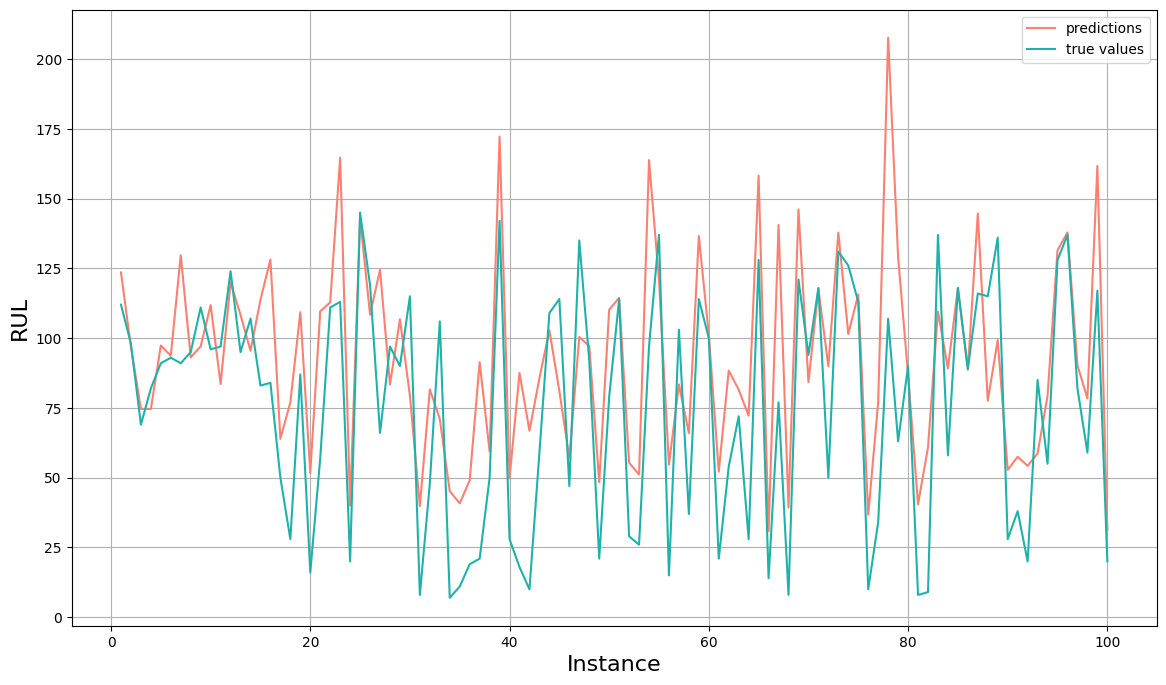

<Figure size 640x480 with 0 Axes>

In [ ]:
if DisplayGraph == 1:
    X_adv_np, y_adv_np = UtilsTool.prepare_batch(X.cpu().detach(), y.cpu())
    y_pred = UtilsTool.exp_degradation(X_adv_np, *Param)
    UtilsTool.DisplayGraph(torch.tensor(y_pred).cpu(), y, FiguresPath, "NormalStatsDetection")

In [ ]:
print(UtilsTool.GetStatsInfos(X, y, 0, PRNNAdversarialDataFgsm,  Param))
print(UtilsTool.GetStatsInfos(X, y, 0, PRNNAdversarialDataBim, Param))
print(UtilsTool.GetStatsInfos(X, y, 0, PRNNAdversarialDataCW, Param))
print(UtilsTool.GetStatsInfos(X, y, 0, PRNNAdversarialDataMaillardL0, Param))
print(UtilsTool.GetStatsInfos(X, y, 0, PRNNAdversarialDataMaillardL2, Param))
print()
print(UtilsTool.GetStatsInfos(X, y, 0, PGRUAdversarialDataFgsm,  Param))
print(UtilsTool.GetStatsInfos(X, y, 0, PGRUAdversarialDataBim, Param))
print(UtilsTool.GetStatsInfos(X, y, 0, PGRUAdversarialDataCW, Param))
print(UtilsTool.GetStatsInfos(X, y, 0, PGRUAdversarialDataMaillardL0, Param))
print(UtilsTool.GetStatsInfos(X, y, 0, PGRUAdversarialDataMaillardL2, Param))
print()
print(UtilsTool.GetStatsInfos(X, y, 0, PLSTMAdversarialDataFgsm,  Param))
print(UtilsTool.GetStatsInfos(X, y, 0, PLSTMAdversarialDataBim, Param))
print(UtilsTool.GetStatsInfos(X, y, 0, PLSTMAdversarialDataCW, Param))
print(UtilsTool.GetStatsInfos(X, y, 0, PLSTMAdversarialDataMaillardL0, Param))
print(UtilsTool.GetStatsInfos(X, y, 0, PLSTMAdversarialDataMaillardL2, Param))

{'RealRUL': 75.5199966430664, 'Objective': 0, 'PredRUL': 75.55150604248047, 'RMSE_adversarial': 0.05165866494824088, 'RMSE_pred': 31.25596046447754}
{'RealRUL': 75.5199966430664, 'Objective': 0, 'PredRUL': 77.1551513671875, 'RMSE_adversarial': 0.04939906142822384, 'RMSE_pred': 29.032367706298828}
{'RealRUL': 75.5199966430664, 'Objective': 0, 'PredRUL': 69.46842956542969, 'RMSE_adversarial': 0.07743207187550083, 'RMSE_pred': 34.06901550292969}
{'RealRUL': 75.5199966430664, 'Objective': 0, 'PredRUL': 86.3135757446289, 'RMSE_adversarial': 0.04563381628763815, 'RMSE_pred': 29.084674835205078}
{'RealRUL': 75.5199966430664, 'Objective': 0, 'PredRUL': 84.102783203125, 'RMSE_adversarial': 0.042427818936816, 'RMSE_pred': 28.860530853271484}

{'RealRUL': 75.5199966430664, 'Objective': 0, 'PredRUL': 79.31034088134766, 'RMSE_adversarial': 0.051659066001472534, 'RMSE_pred': 26.411399841308594}
{'RealRUL': 75.5199966430664, 'Objective': 0, 'PredRUL': 74.5400161743164, 'RMSE_adversarial': 0.059258066